# K nearest neighbors

KNN falls in the supervised learning family of algorithms. Informally, this means that we are given a labelled dataset consiting of training observations (x, y) and would like to capture the relationship between x and y. More formally, our goal is to learn a function h: X→Y so that given an unseen observation x, h(x) can confidently predict the corresponding output y.

In this module we will explore the inner workings of KNN, choosing the optimal K values and using KNN from scikit-learn.

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime

## Overview

1. Read the problem statement.

2. Get the dataset.

3. Explore the dataset.

4. Pre-processing of dataset.

5. Visualization

6. Transform the dataset for building machine learning model.

7. Split data into train, test set.

8. Build Model.

9. Apply the model.

10. Evaluate the model.

11. Finding Optimal K value

12. Repeat 7, 8, 9 steps.

# Breast cancer dataset

## Read data

### Question 1
Read the data given in bc2.csv file

In [86]:
bc2 = pd.read_csv('bc2.csv')

## Data preprocessing

### Question 2
Observe the no.of records in dataset and type of each column

In [87]:
bc2.shape

(699, 11)

In [88]:
bc2.dtypes

ID                              int64
ClumpThickness                  int64
Cell Size                       int64
Cell Shape                      int64
Marginal Adhesion               int64
Single Epithelial Cell Size     int64
Bare Nuclei                    object
Normal Nucleoli                 int64
Bland Chromatin                 int64
Mitoses                         int64
Class                           int64
dtype: object

### Question 3
Use summary statistics to check if missing values, outlier and encoding treament is necessary

Hint: use **describe()**

In [89]:
bc2.describe()

,ID,ClumpThickness,Cell Size,Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Normal Nucleoli,Bland Chromatin,Mitoses,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [113]:
bc2.columns

Index(['ID', 'ClumpThickness', 'Cell Size', 'Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Normal Nucleoli',
       'Bland Chromatin', 'Mitoses', 'Class'],
      dtype='object')

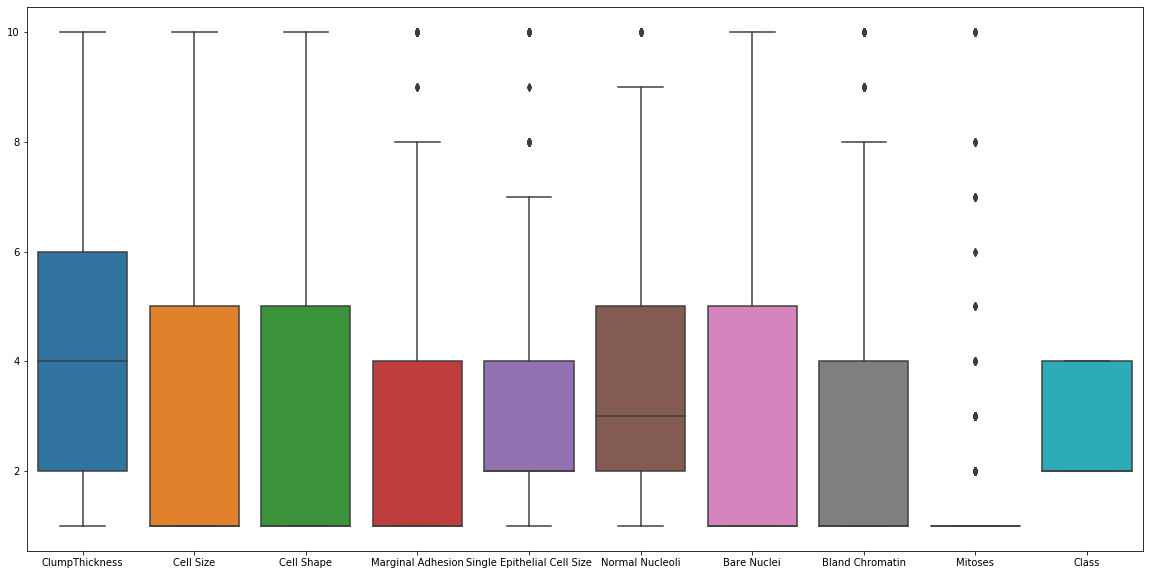

In [121]:
plt.figure(figsize = (20,10))
sns.boxplot(data = bc2[['ClumpThickness', 'Cell Size', 'Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Normal Nucleoli','Bare Nuclei',
       'Bland Chromatin', 'Mitoses', 'Class']])

In [120]:
print('Seems like Mitoses is full of outliers')

Seems like Mitoses is full of outliers


#### Check Missing Values

In [90]:
bc2.isna().any()

ID                             False
ClumpThickness                 False
Cell Size                      False
Cell Shape                     False
Marginal Adhesion              False
Single Epithelial Cell Size    False
Bare Nuclei                    False
Normal Nucleoli                False
Bland Chromatin                False
Mitoses                        False
Class                          False
dtype: bool

In [91]:
print('There are no missing values')

There are no missing values


### Question 4
#### Check how many `?` are there in Bare Nuclei feature (they are also unknown or missing values). 

In [92]:
bc2[bc2['Bare Nuclei'] == '?'].shape

(16, 11)

In [93]:
print('There are 16 missing values!')

There are 16 missing values!


#### Replace them with the 'top' value of the describe function of Bare Nuclei feature

Hint: give value of parameter include='all' in describe function

In [94]:
#Getting the top value
bc2['Bare Nuclei'].describe()

count     699
unique     11
top         1
freq      402
Name: Bare Nuclei, dtype: object

In [95]:
print('The top value is 1')

The top value is 1


In [96]:
bc2.replace({'Bare Nuclei': {'?': '1'}}, regex=False, inplace=True)

### Question 5
#### Find the distribution of target variable (Class) 

In [102]:
bc2.Class.value_counts()

2    458
4    241
Name: Class, dtype: int64

In [101]:
print('Seems like the class is skewed towards 2')

Seems like the class is slightly skewed towards 2


#### Plot the distribution of target variable using histogram

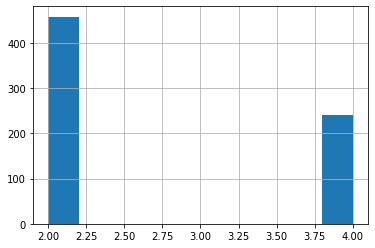

In [103]:
bc2['Class'].hist()

#### Convert the datatype of Bare Nuclei to `int`

In [108]:
bc2['Bare Nuclei'] = bc2['Bare Nuclei'].astype('int64')

In [110]:
bc2.dtypes

ID                             int64
ClumpThickness                 int64
Cell Size                      int64
Cell Shape                     int64
Marginal Adhesion              int64
Single Epithelial Cell Size    int64
Bare Nuclei                    int64
Normal Nucleoli                int64
Bland Chromatin                int64
Mitoses                        int64
Class                          int64
dtype: object

## Scatter plot

### Question 6
Plot Scatter Matrix to understand the distribution of variables and check if any variables are collinear and drop one of them.

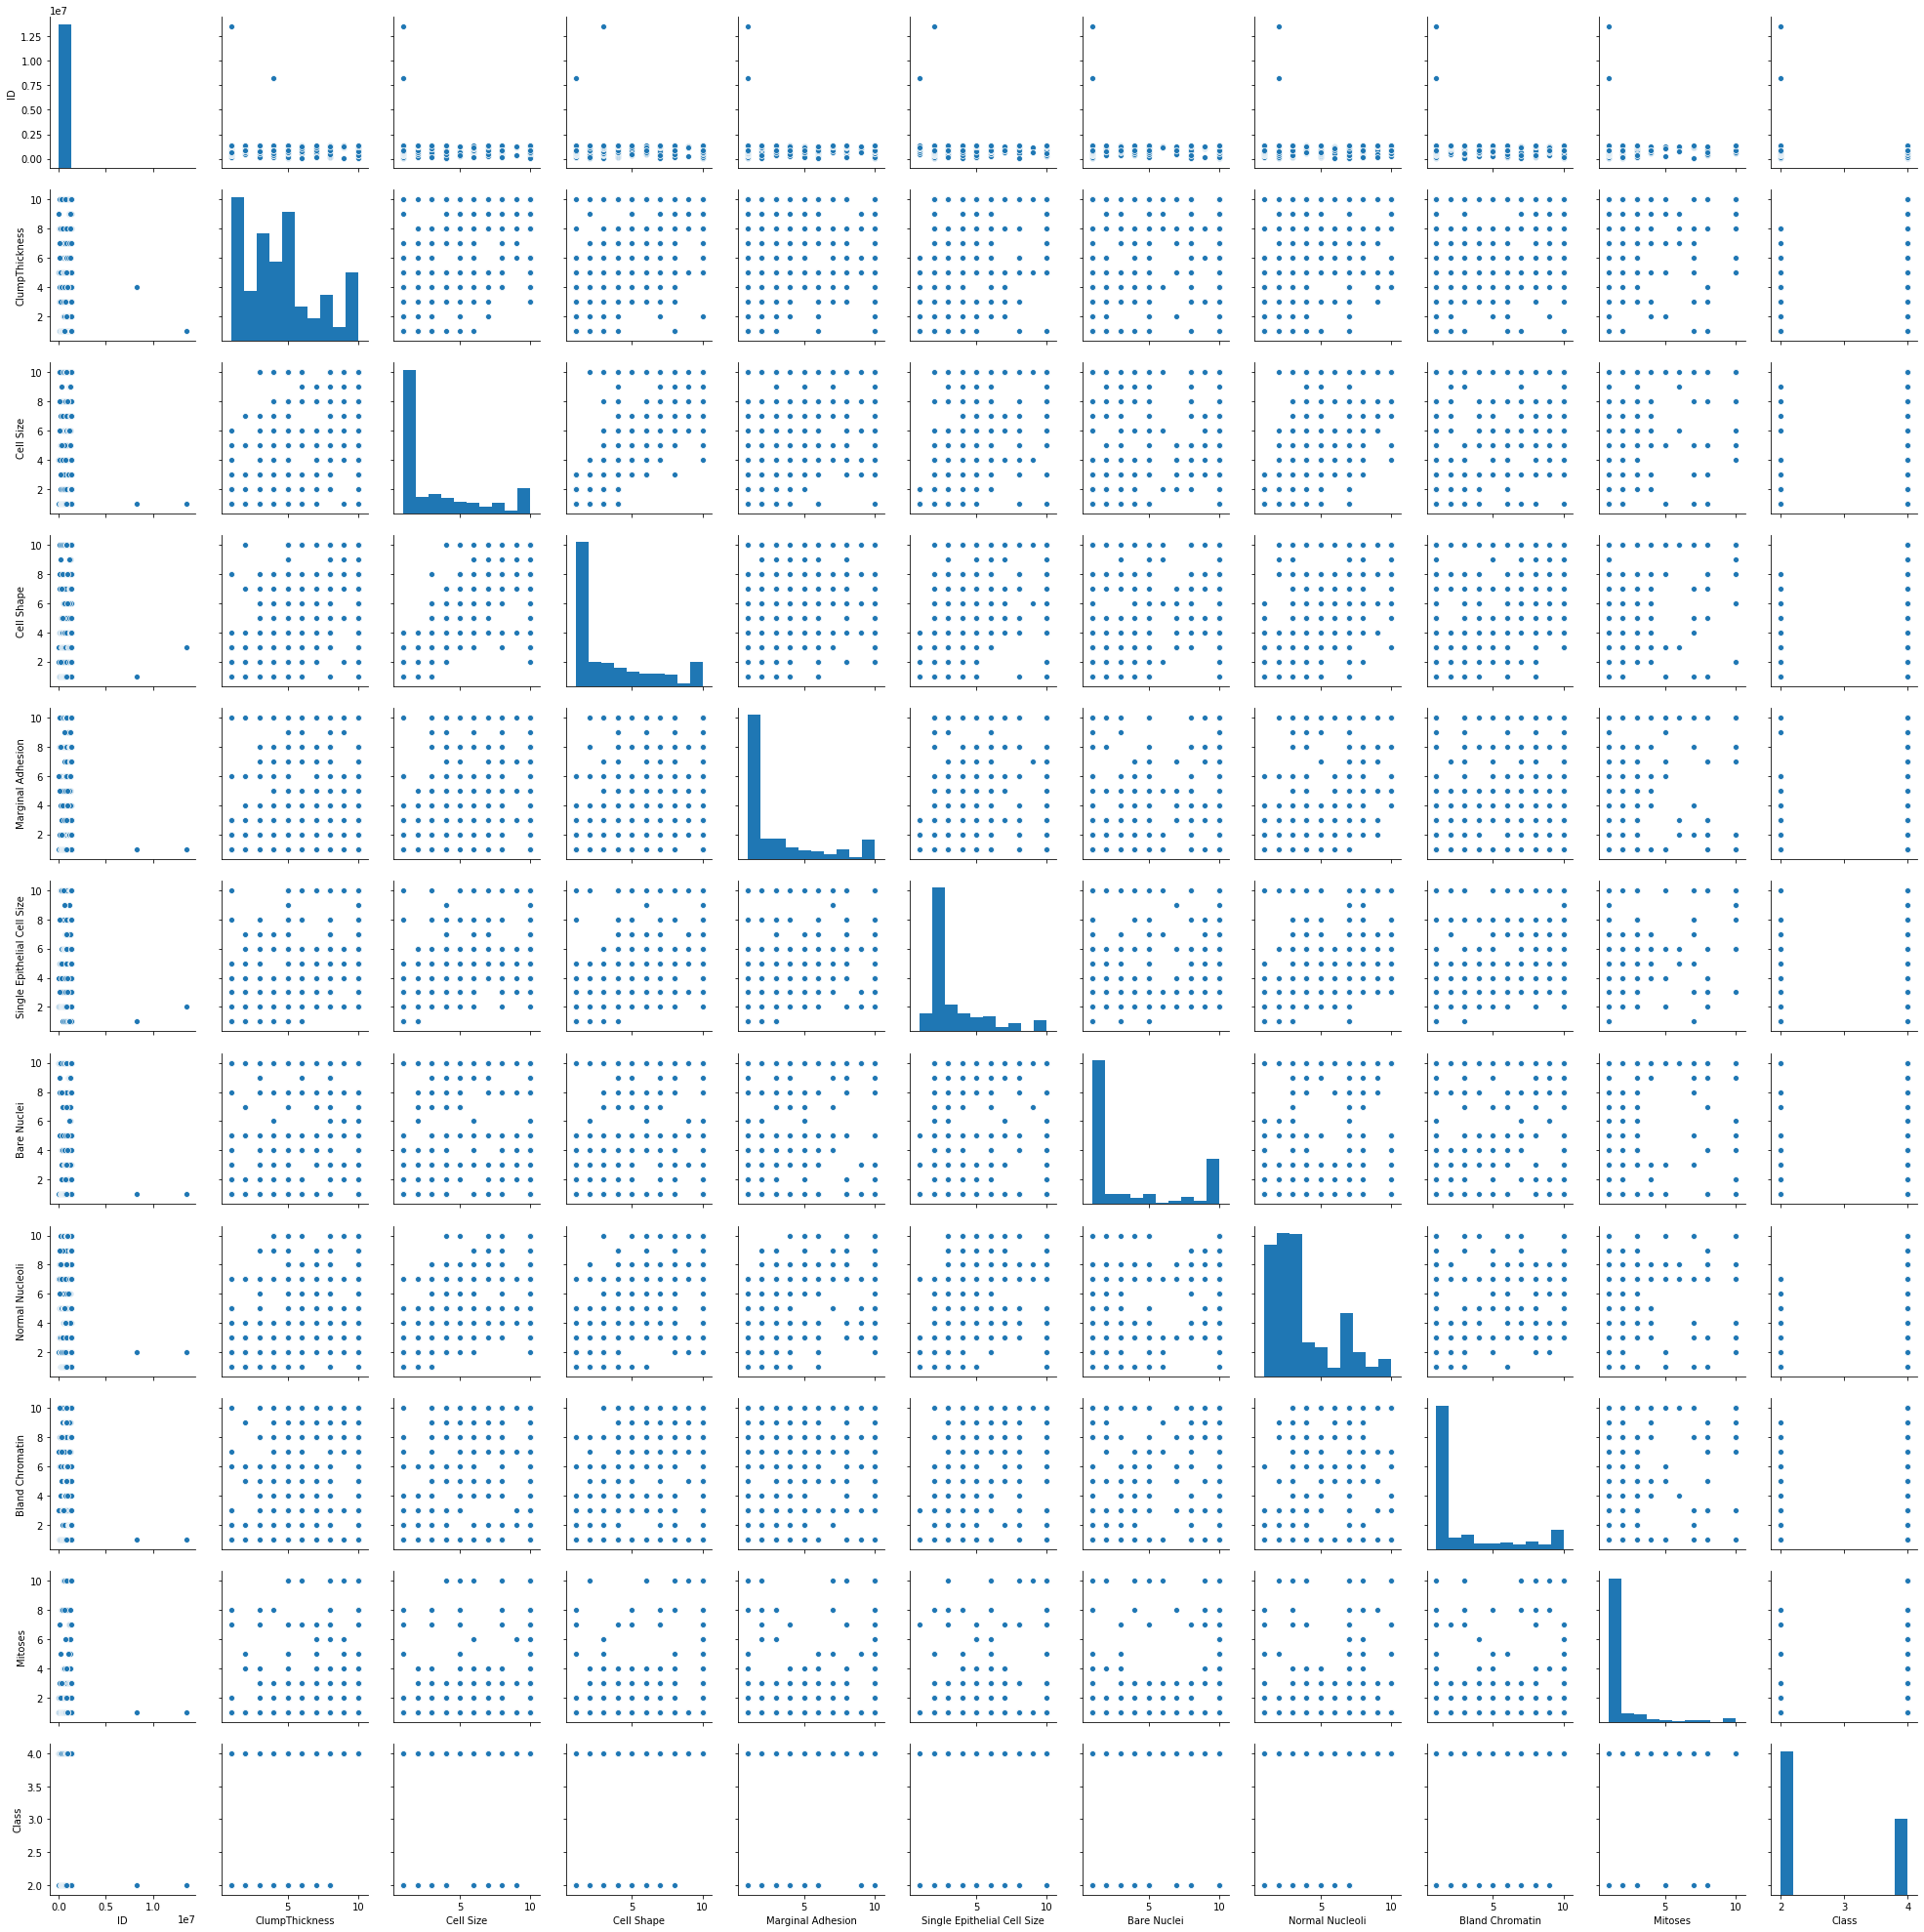

In [124]:
sns.pairplot(bc2)

In [127]:
print('Lets drop the Mitoses column as it has the lowest correlation with class ~ 0.42')

Lets drop the Mitoses column as it has the lowest correlation with class ~ 0.42


In [129]:
#Dropping the mitoses column
bc2.drop(labels = 'Mitoses', axis = 1, inplace=True)

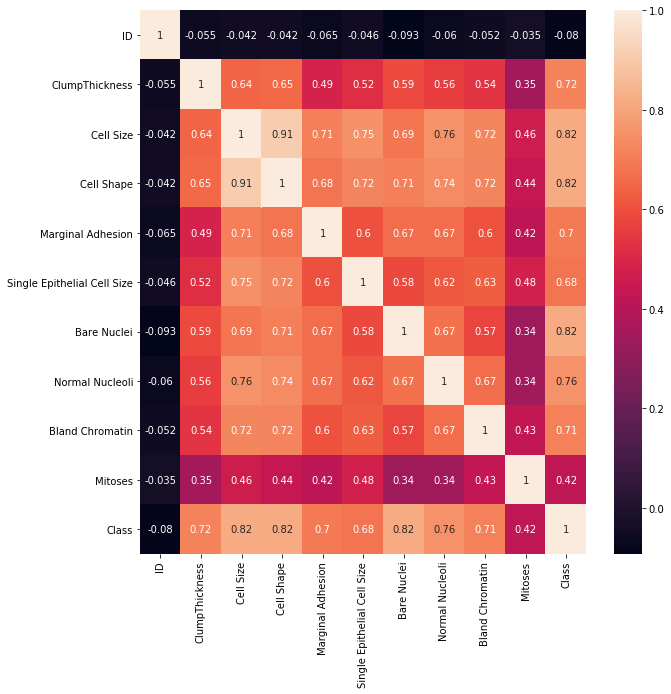

In [126]:
plt.figure(figsize = (10,10))
sns.heatmap(bc2.corr(), annot=True)

## Train test split

### Question 7
#### Divide the dataset into feature set and target set

In [130]:
bc2.columns

Index(['ID', 'ClumpThickness', 'Cell Size', 'Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Normal Nucleoli',
       'Bland Chromatin', 'Class'],
      dtype='object')

In [137]:
#Creating the Feature Set
X = bc2[['ClumpThickness', 'Cell Size', 'Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Normal Nucleoli',
       'Bland Chromatin']]

In [133]:
#Creating the Target Set
y = bc2['Class']

#### Divide the Training and Test sets in 70:30 

In [134]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Scale the data

### Question 8
Standardize the data

Hint: use **StandardScaler()**

In [138]:
#Scaling the features using zscore
X_train = X_train.apply(zscore)
X_test = X_test.apply(zscore)

## Build Model

### Question 9

Build the model and train and test on training and test sets respectively using **scikit-learn**.

Print the Accuracy of the model with different values of **k = 3, 5, 9**

Hint: For accuracy you can check **accuracy_score()** in scikit-learn

In [145]:
K = [3,5,9]
for k in K:
    #Initializing the model
    NNH = KNeighborsClassifier(n_neighbors= k, weights = 'uniform', metric='euclidean')
    #Fitting the training set
    NNH.fit(X_train, y_train)
    #Predicting the y
    y_hat = NNH.predict(X_test)
    #Finding accuracy
    y_test_pred = NNH.predict(X_test)
    y_train_pred = NNH.predict(X_train)
    print('For k = %i the test accuracy = %.3f and the train accuracy = %.3f'\
      %(k,accuracy_score(y_test, y_test_pred),accuracy_score(y_train, y_train_pred))) 

For k = 3 the test accuracy = 0.990 and the train accuracy = 1.000
For k = 5 the test accuracy = 0.981 and the train accuracy = 1.000
For k = 9 the test accuracy = 0.971 and the train accuracy = 1.000


## Find optimal value of K

### Question 10
Finding Optimal value of k

- Run the KNN with no of neighbours to be 1, 3, 5 ... 19
- Find the **optimal number of neighbours** from the above list

In [158]:
now = datetime.now()
accuracy_test = []
accuracy_train = []
for k in np.arange(1,20,2):
    #Initializing the model
    NNH = KNeighborsClassifier(n_neighbors= k, weights = 'uniform', metric='euclidean')
    #Fitting the training set
    NNH.fit(X_train, y_train)
    #Predicting the y
    y_hat = NNH.predict(X_test)
    #Finding accuracy
    y_test_pred = NNH.predict(X_test)
    y_train_pred = NNH.predict(X_train)
    print('For k = %i test accuracy = %.3f\n'%(k,accuracy_score(y_test, y_test_pred)))
    accuracy_test.append(accuracy_score(y_test, y_test_pred))
    accuracy_train.append(accuracy_score(y_train, y_train_pred))
    end = datetime.now()

For k = 1 test accuracy = 0.976

For k = 3 test accuracy = 0.990

For k = 5 test accuracy = 0.986

For k = 7 test accuracy = 0.971

For k = 9 test accuracy = 0.971

For k = 11 test accuracy = 0.971

For k = 13 test accuracy = 0.967

For k = 15 test accuracy = 0.967

For k = 17 test accuracy = 0.967

For k = 19 test accuracy = 0.967



In [162]:
print('We see that best k value = 3')

We see that best k value = 3


## Plot accuracy

### Question 11

Plot accuracy score vs k (with k value on X-axis) using matplotlib.

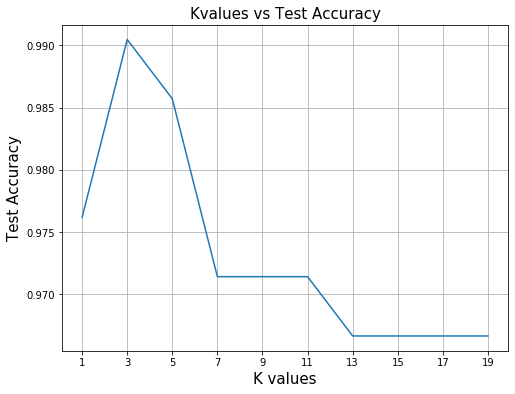

In [164]:
plt.figure(figsize = (8,6))
plt.xlabel('K values', fontsize = 15)
plt.ylabel('Test Accuracy', fontsize = 15)
plt.grid(True)
plt.title('Kvalues vs Test Accuracy', fontsize = 15)
plt.xticks(np.arange(1,20,2))
#plt.yticks(np.arange(0.70,0.76,0.005))
plt.plot(np.arange(1,20,2),accuracy_test)